In [1]:
import gym
import gym_Snake
import time
import sys
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os

#### QLearning algorithm

In [2]:
class QLearning:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.9, min_epsilon = 0.1, decay = 1):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.chronology = []
        
    def update_epsilon(self):
#         if self.epsilon > self.min_epsilon: self.epsilon = 1 / (1 / self.epsilon + self.decay)
        if self.epsilon > self.min_epsilon: self.epsilon = self.epsilon * self.decay
            
    def act(self):
        if (np.random.uniform() < self.epsilon):
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[self.state, :])
    
    def update(self, action, reward, state, add_batch=True):
        if add_batch: self.chronology.append([self.state, action, reward, state])
        self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])        
#         self.alpha += 1 / ( self.alpha + self.decay)
        self.state = state

    def reset(self, state):
        self.state = state
        
    def play_batch(self, nb_batchs):
        prev_state = self.state
        arr = np.array(self.chronology)
        for s,a,r,sn in arr[np.random.choice(arr.shape[0], size=nb_batchs, replace=False), :]:
            # Reset position
            self.reset(s)
            # Update algorithm
            self.update(a, r, sn, add_batch = False)
        # Reset real state
        self.reset(prev_state)


In [3]:
class SARSA:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.1, min_epsilon = 0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.state = 0  # Set initial state
        self.chronology = []
        
        
    def update_epsilon(self):
#         if self.epsilon > self.min_epsilon: self.epsilon = 1 / (1 / self.epsilon + self.decay)
        if self.epsilon > self.min_epsilon: self.epsilon = self.epsilon * self.decay
            
    def act(self):
        ## by default, act greedily
        if (np.random.uniform() < self.epsilon):
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[self.state, :])

    def update(self, action, reward, state, add_batch = True):
        if add_batch: self.chronology.append([self.state, action, reward, state])
        ## fill in
        next_action = np.argmax(self.Q[state, :])
        self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])        
        self.Q[self.state, action] = self.alpha * (reward + self.discount * self.Q[state, next_action]) + (1 - self.alpha) * self.Q[self.state, action]
        self.state = state

    def reset(self, state):
        self.state = state
        
    def play_batch(self, nb_batchs):
        prev_state = self.state
        arr = np.array(self.chronology)
        for s,a,r,sn in arr[np.random.choice(arr.shape[0], size=nb_batchs, replace=False), :]:
            # Reset position
            self.reset(s)
            # Update algorithm
            self.update(a, r, sn, add_batch = False)
        # Reset real state
        self.reset(prev_state)

#### Create env

In [4]:
reward_eat = 1

custom_rewards = {
    "REWARD_TARGET": reward_eat,
    "REWARD_COLLISION": -1,
    "REWARD_TOWARD": 0,
    "REWARD_AWAY": 0
}

train_env_name = 'Double_v'

env = gym.make('Snake-v0', 
               player = 'computer', 
               shape = train_env_name, 
               state_mode = 'states', 
               reward_mode = 'normal', 
               width = 10, 
               height = 10, 
               solid_border = True,
               rewards = custom_rewards)
print(env.observation_space)
print(env.action_space)

Discrete(1024)
Discrete(3)


#### Iteration logic

In [5]:
def play_epoch(algo, env, render = False, sleep_time = 0.5):
    
    # Reset env
    obs = env.reset()
    algo.reset(obs)

    done = False
    
    # Sum the rewards
    total_rew = 0
    i = 0
    eated = 0
    
    while not done:
        # Show
        if render: env.render()
        # Choose next action
        new_act = algo.act()
        # Act in the env
        obs, reward, done, info = env.step(new_act)
        # Store reward
        total_rew += reward
        if reward == reward_eat: eated += 1
        # Update algorithm
        algo.update(new_act, reward, obs)
        # Slow render
        if render: time.sleep(sleep_time)
        i += 1
            
    # Return total reward
    return total_rew, eated, i

#### Init QLearning algorithm

In [6]:
# Compute decai in order to reach given value after n iterations
n = 70000
initial_epsilon = 1
min_epsilon = 0.01
opt_decay = (min_epsilon / initial_epsilon)**(1/n)

In [7]:
# QL = QLearning(n_actions = env.action_space.n,
#                 n_states = env.observation_space.n, 
#                 discount=0.9, 
#                 alpha = 0.1, 
#                 epsilon=1, 
#                 decay = 0.00001)

QL = QLearning(n_actions = env.action_space.n,
               n_states = env.observation_space.n, 
               discount = 0.9, 
               alpha = 0.2, 
               epsilon = initial_epsilon, 
               min_epsilon = min_epsilon,
               decay = opt_decay)

SA = SARSA(n_actions = env.action_space.n, 
           n_states = env.observation_space.n,
           discount = 0.9,
           alpha = 0.2,
           epsilon = initial_epsilon,
           min_epsilon = min_epsilon,
           decay = opt_decay)



#### Train

In [8]:
render = True

nb_iterations = 100000

rewards = []
eps = []

my_algo_name = 'QL' # 'QL' 'SARSA'
my_algo = SA if my_algo_name == 'SARSA' else QL # QL or SA

# Train
for i in tqdm(range(nb_iterations)):
    # Play a game
    r, _, _ = play_epoch(algo = my_algo, env = env, render = False)
    
    # Keep track of reward
    rewards.append(r)
    eps.append(my_algo.epsilon)
    
    # Update epsilon
    my_algo.update_epsilon()
    
    # Play batch
    if i > 1000 and i % 1000 == 0:
        my_algo.play_batch(min(i - 1, 5000))
        
    # Manually update epsilon
#     if i == 150000:
#         my_algo.epsilon = .5
#     if i == 300000:
#         my_algo.epsilon = .2
#     if i == 400000:
#         my_algo.epsilon = 0


100%|██████████████████████████████████| 100000/100000 [14:05<00:00, 118.30it/s]


In [9]:
os.getcwd()

'/home/jonas/Documents/University/RLDMUU/RL_Project/Tests'

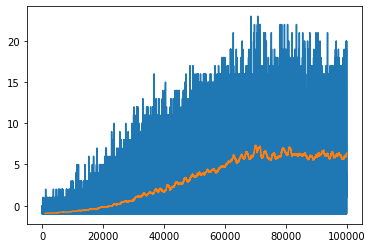

In [10]:
# Plot rewards
plt.plot(range(len(rewards)), rewards)
# Plot moving average
plt.plot(range(len(rewards)), pd.Series(rewards).rolling(1000).mean())
# Save plot
plt.savefig(f'QL_results/{my_algo_name}_epochs_{nb_iterations}_batch_1000_x_5000_epsilon_{n}_train_{train_env_name}.png')

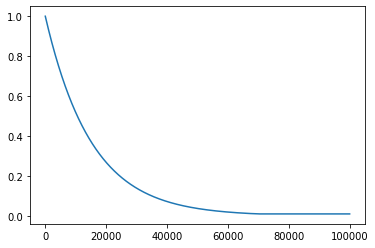

In [11]:
plt.plot(range(len(eps)), eps)

#### Visualize results

In [12]:
# # # # Replay with last policy
# old_eps = my_algo.epsilon
# my_algo.epsilon = 0
# play_epoch(algo = my_algo, env = env, render = True)
# my_algo.epsilon = old_eps

In [13]:
# If run cell 'visualize results'
# np.save('../../../Tests/QL_results/SARSA_epochs_500000_batch_1000_x_5000_.npy', my_algo.Q)

In [14]:
# else
np.save(f'QL_results/{my_algo_name}_epochs_{nb_iterations}_batch_1000_x_5000_epsilon_{n}_train_{train_env_name}.npy', my_algo.Q)

In [38]:
custom_rewards = {
    "REWARD_TARGET": reward_eat,
    "REWARD_COLLISION": -1,
    "REWARD_TOWARD": 0,
    "REWARD_AWAY": 0
}

env_name = 'Double_v'

new_env = gym.make('Snake-v0', 
               player = 'computer', 
               shape = env_name, 
               state_mode = 'states', 
               reward_mode = 'normal', 
               width = 10, 
               height = 10, 
               solid_border = True,
               rewards = custom_rewards)

In [40]:
my_algo_name = 'QL'
nb_iterations = 100000

# Ensure the current working directory is correct
filepath = globals()['_dh'][0]
os.chdir(filepath)

table = np.load(f'QL_results/{my_algo_name}_epochs_{nb_iterations}_batch_1000_x_5000_epsilon_{n}.npy')

my_algo_test = SA if my_algo_name == 'SARSA' else QL
my_algo_test.Q = table
my_algo_test.epsilon = 0.01


nb_tests = 200

times = []
steps = []
eated = []
rewards = []
 

for _ in tqdm(range(nb_tests)):
    start = time.time()
    r, e, i = play_epoch(algo = my_algo_test, env = new_env, render = False)
    stop = time.time()
    times.append(stop - start)
    steps.append(i)
    eated.append(e)
    rewards.append(r)
    
print('\n#########################')
print(f'After {nb_tests} tests with  {my_algo_name}:')
print(f'Env: {env_name}')
print(f'Average targets eated:       {np.mean(eated)}')
# print(f'Average reward:              {np.mean(rewards)}')
print(f'Max rewards eated:           {np.max(eated)}')
print(f'Median of rewards eated:     {np.median(eated)}')
print(f'Average time per simulation: {np.mean(times)}')
print(f'Average time per step: {np.sum(times) / np.sum(steps)}')

100%|█████████████████████████████████████████| 200/200 [00:27<00:00,  7.17it/s]


#########################
After 200 tests with  QL:
Env: Double_v
Average targets eated:       4.235
Max rewards eated:           14
Median of rewards eated:     4.0
Average time per simulation: 0.11650198340415954
Average time per step: 0.0006181460359959651
